In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import string
import re
import demoji
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, SpatialDropout1D, Dropout, BatchNormalization, Flatten
from keras.regularizers import l2
from keras.optimizers import Adam

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
tweet_data=pd.read_csv("cyberbullying_data.csv")

In [3]:
tweet_data.shape

(24783, 7)

In [4]:
tweet_data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
tweet_data = tweet_data.drop(['Unnamed: 0'],axis=1)

In [6]:
tweet_data.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [7]:
tweet_data.isna().sum()

count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [8]:
tweet_data.duplicated().sum()

0

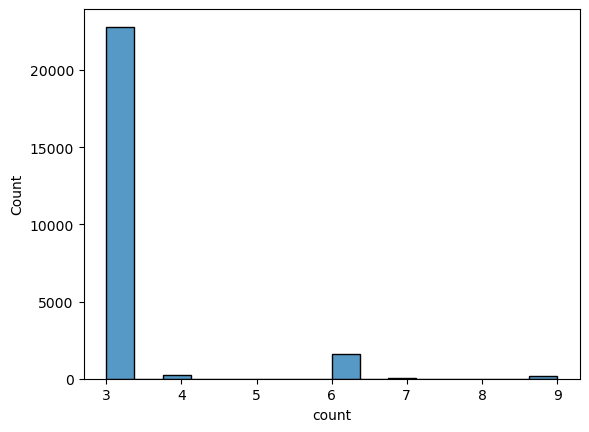

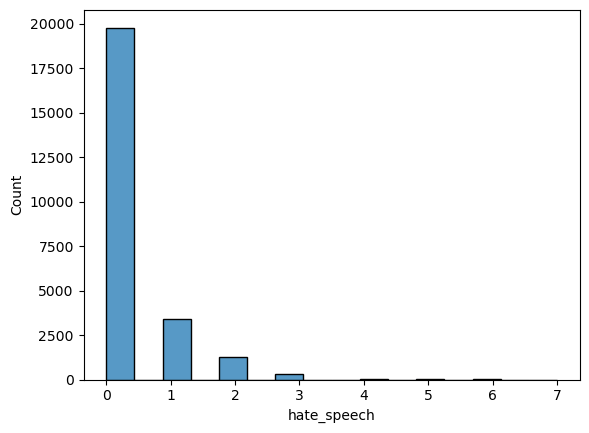

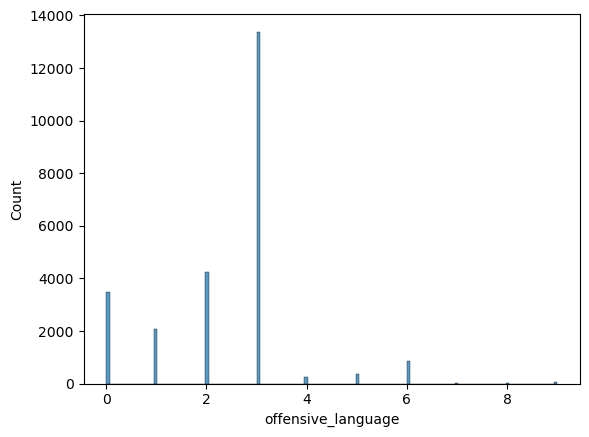

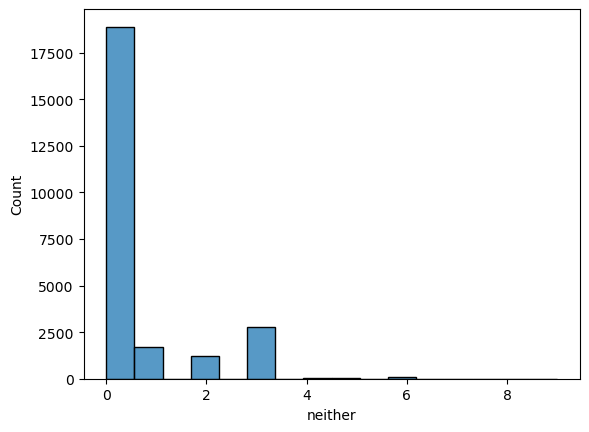

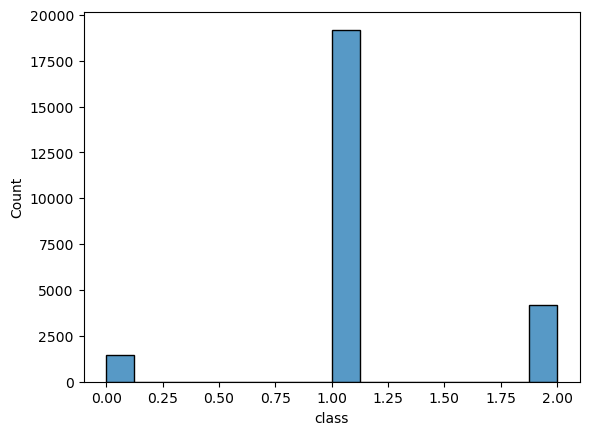

In [9]:
for col in tweet_data[['count', 'hate_speech', 'offensive_language', 'neither', 'class']]:
    sns.histplot(tweet_data[col])
    plt.show()

In [11]:
tweet_data.describe()

,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247,1.110277
std,0.883060,0.631851,1.399459,1.113299,0.462089
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000,1.000000
50%,3.000000,0.000000,3.000000,0.000000,1.000000
75%,3.000000,0.000000,3.000000,0.000000,1.000000
max,9.000000,7.000000,9.000000,9.000000,2.000000


In [12]:
tweet_data[tweet_data['hate_speech']>0].describe()

,count,hate_speech,offensive_language,neither,class
count,4993.000000,4993.000000,4993.000000,4993.000000,4993.000000
mean,3.382936,1.392349,1.827759,0.162828,0.764070
std,1.124272,0.658461,1.256703,0.594213,0.530344
min,3.000000,1.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,1.000000,0.000000,0.000000
50%,3.000000,1.000000,2.000000,0.000000,1.000000
75%,3.000000,2.000000,2.000000,0.000000,1.000000
max,9.000000,7.000000,8.000000,8.000000,2.000000


In [13]:
tweet_data[tweet_data['offensive_language']>0].describe()

,count,hate_speech,offensive_language,neither,class
count,21308.000000,21308.000000,21308.000000,21308.000000,21308.000000
mean,3.263328,0.266942,2.807349,0.189037,1.000751
std,0.916658,0.578783,1.082944,0.572051,0.315283
min,3.000000,0.000000,1.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000,1.000000
50%,3.000000,0.000000,3.000000,0.000000,1.000000
75%,3.000000,0.000000,3.000000,0.000000,1.000000
max,9.000000,7.000000,9.000000,8.000000,2.000000


In [14]:
tweet_data[tweet_data['neither']>0].describe()

,count,hate_speech,offensive_language,neither,class
count,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000
mean,3.248175,0.108301,0.829231,2.310643,1.685113
std,0.899459,0.422802,1.138030,1.069688,0.508816
min,3.000000,0.000000,0.000000,1.000000,0.000000
25%,3.000000,0.000000,0.000000,1.000000,1.000000
50%,3.000000,0.000000,0.000000,3.000000,2.000000
75%,3.000000,0.000000,2.000000,3.000000,2.000000
max,9.000000,7.000000,8.000000,9.000000,2.000000


In [36]:
unique_values = tweet_data['class'].unique()
unique_values

array([2, 1, 0], dtype=int64)

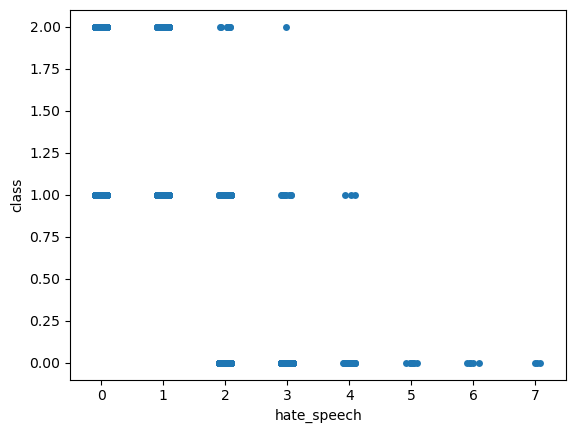

In [15]:
sns.stripplot(data=tweet_data, x="hate_speech", y="class")
plt.show()

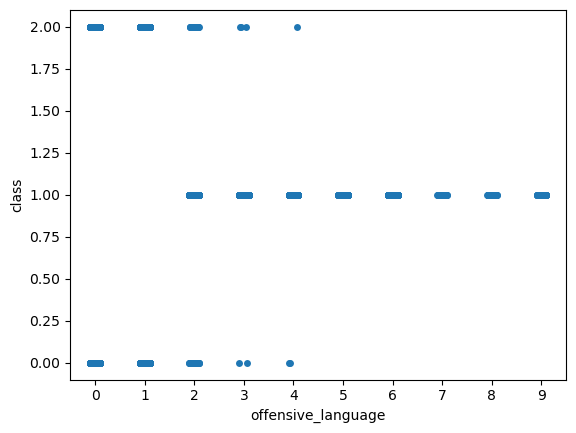

In [16]:
sns.stripplot(data=tweet_data, x="offensive_language", y="class")
plt.show()

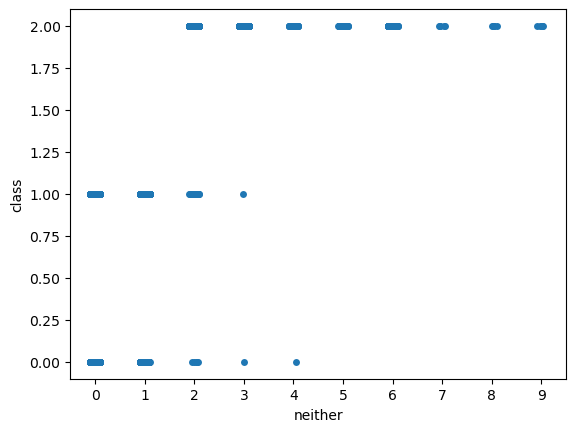

In [17]:
sns.stripplot(data=tweet_data, x="neither", y="class")
plt.show()

Text(0.5, 1.0, 'Distribution of Class')

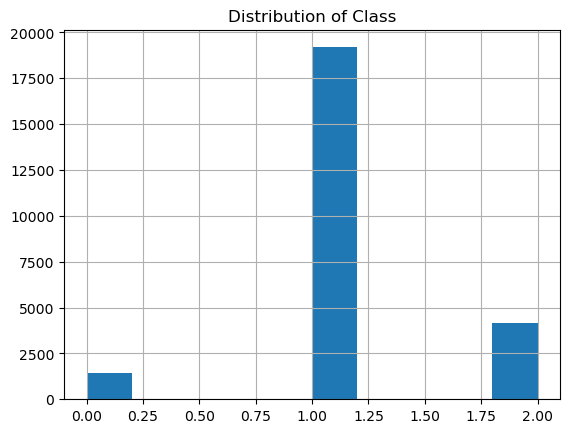

In [41]:
ax = tweet_data['class'].hist()
ax.set_title("Distribution of Class")

# **PREPROCESSING USING NLP TECHNIQUES**

In [42]:
tweet_data["tweet"] = tweet_data["tweet"].astype(str)

In [43]:
print(string.punctuation)
def remove_punctuation(tweet):
    punctuationfree="".join([i for i in tweet if i not in string.punctuation])
    return punctuationfree

tweet_data['preprocess_tweet']= tweet_data['tweet'].apply(lambda x:remove_punctuation(x))
tweet_data.head()

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


,count,hate_speech,offensive_language,neither,class,tweet,preprocess_tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,RT mayasolovely As a woman you shouldnt compl...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,RT mleew17 boy dats coldtyga dwn bad for cuff...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,RT UrKindOfBrand Dawg RT 80sbaby4life You eve...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,RT CGAnderson vivabased she look like a tranny
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,RT ShenikaRoberts The shit you hear about me ...


In [44]:
tweet_data['preprocess_tweet']= tweet_data['preprocess_tweet'].apply(lambda x: x.lower())
tweet_data.head()

,count,hate_speech,offensive_language,neither,class,tweet,preprocess_tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,rt mayasolovely as a woman you shouldnt compl...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt mleew17 boy dats coldtyga dwn bad for cuff...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt urkindofbrand dawg rt 80sbaby4life you eve...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt cganderson vivabased she look like a tranny
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt shenikaroberts the shit you hear about me ...


In [45]:
def tokenization(tweet):
    tokens = re.split('W+',tweet)
    return tokens

tweet_data['preprocess_tweet']= tweet_data['preprocess_tweet'].apply(lambda x: tokenization(x))
tweet_data.head()

,count,hate_speech,offensive_language,neither,class,tweet,preprocess_tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,[ rt mayasolovely as a woman you shouldnt comp...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,[ rt mleew17 boy dats coldtyga dwn bad for cuf...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,[ rt urkindofbrand dawg rt 80sbaby4life you ev...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,[ rt cganderson vivabased she look like a tranny]
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,[ rt shenikaroberts the shit you hear about me...


In [46]:
vocab_size = len(tweet_data['preprocess_tweet']) + 1 
vocab_size

24784

In [47]:
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords[0:10])

def remove_stopwords(Tweet):
    output= [i for i in Tweet if i not in stopwords]
    return output

tweet_data['preprocess_tweet']= tweet_data['preprocess_tweet'].apply(lambda x:remove_stopwords(x))
tweet_data.head()

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


,count,hate_speech,offensive_language,neither,class,tweet,preprocess_tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,[ rt mayasolovely as a woman you shouldnt comp...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,[ rt mleew17 boy dats coldtyga dwn bad for cuf...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,[ rt urkindofbrand dawg rt 80sbaby4life you ev...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,[ rt cganderson vivabased she look like a tranny]
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,[ rt shenikaroberts the shit you hear about me...


In [48]:
porter_stemmer = PorterStemmer()

def stemming(Tweet):
    stem_Tweet = [porter_stemmer.stem(word) for word in Tweet]
    return stem_Tweet

tweet_data['preprocess_tweet']=tweet_data['preprocess_tweet'].apply(lambda x: stemming(x))
tweet_data.head()

,count,hate_speech,offensive_language,neither,class,tweet,preprocess_tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,[ rt mayasolovely as a woman you shouldnt comp...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,[ rt mleew17 boy dats coldtyga dwn bad for cuf...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,[ rt urkindofbrand dawg rt 80sbaby4life you ev...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,[ rt cganderson vivabased she look like a tranni]
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,[ rt shenikaroberts the shit you hear about me...


In [49]:
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatizer(Tweet):
    lemm_Tweet = [wordnet_lemmatizer.lemmatize(word) for word in Tweet]
    return lemm_Tweet

tweet_data['preprocess_tweet']=tweet_data['preprocess_tweet'].apply(lambda x:lemmatizer(x))
tweet_data.head()

,count,hate_speech,offensive_language,neither,class,tweet,preprocess_tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,[ rt mayasolovely as a woman you shouldnt comp...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,[ rt mleew17 boy dats coldtyga dwn bad for cuf...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,[ rt urkindofbrand dawg rt 80sbaby4life you ev...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,[ rt cganderson vivabased she look like a tranni]
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,[ rt shenikaroberts the shit you hear about me...


In [50]:
def get_sentence(words):
    sentence = ' '.join(words)
    return sentence

tweet_data['preprocess_tweet']=tweet_data['preprocess_tweet'].apply(lambda x: get_sentence(x))
tweet_data.head()

,count,hate_speech,offensive_language,neither,class,tweet,preprocess_tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,rt mayasolovely as a woman you shouldnt compl...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt mleew17 boy dats coldtyga dwn bad for cuff...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt urkindofbrand dawg rt 80sbaby4life you eve...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt cganderson vivabased she look like a tranni
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt shenikaroberts the shit you hear about me ...


In [51]:
def remove_emoji(tweet):
    dem = demoji.findall(tweet)
    for item in dem.keys():
        tweet = tweet.replace(item, '')
    return tweet

tweet_data['preprocess_tweet']= tweet_data['preprocess_tweet'].apply(lambda x: remove_emoji(x))
tweet_data.head()

,count,hate_speech,offensive_language,neither,class,tweet,preprocess_tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,rt mayasolovely as a woman you shouldnt compl...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt mleew17 boy dats coldtyga dwn bad for cuff...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt urkindofbrand dawg rt 80sbaby4life you eve...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt cganderson vivabased she look like a tranni
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt shenikaroberts the shit you hear about me ...


In [52]:
tweet_data_hate = tweet_data[tweet_data["class"]==0]
tweet_data_offensive = tweet_data[tweet_data["class"]==1]
tweet_data_neither = tweet_data[tweet_data["class"]==2]

In [53]:
print(tweet_data_hate.shape)

(1430, 7)


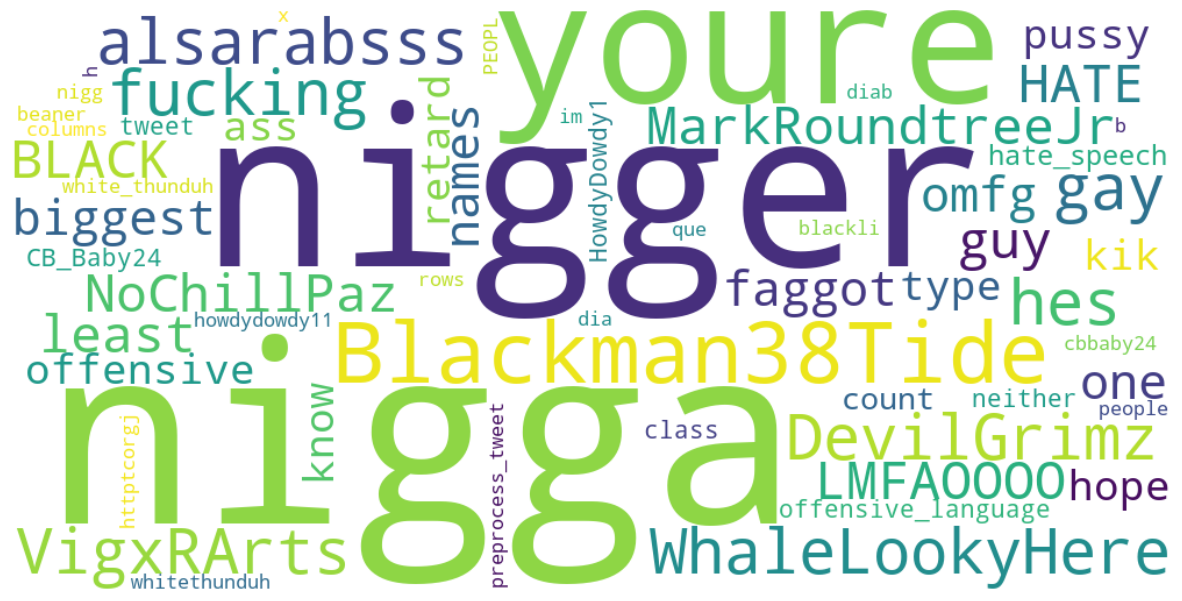

In [59]:
wordcloud = WordCloud(width = 1000, height = 500,
                background_color ='white', max_words=100,
                min_font_size = 10).generate(str(tweet_data_hate))
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

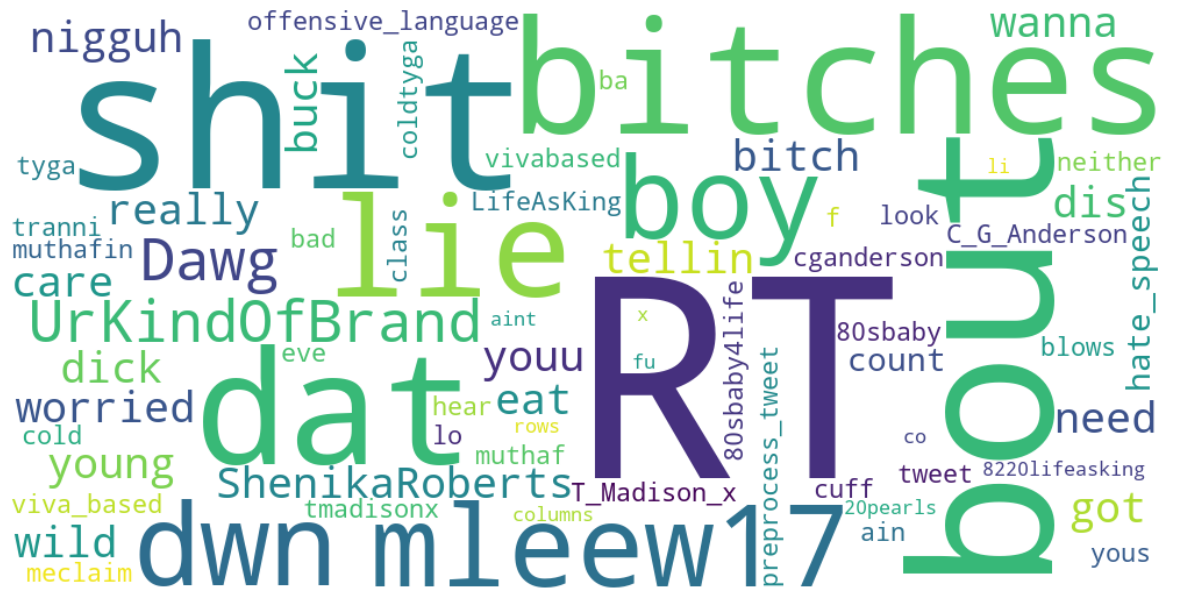

In [60]:
wordcloud = WordCloud(width = 1000, height = 500,
                background_color ='white', max_words=100,
                min_font_size = 10).generate(str(tweet_data_offensive))
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

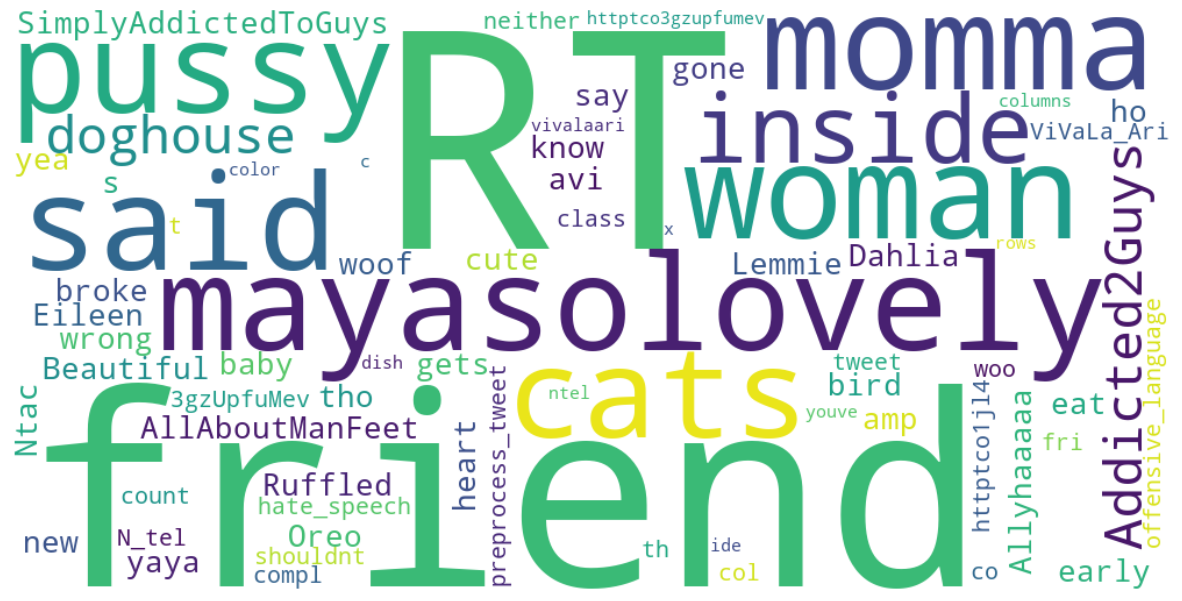

In [61]:
wordcloud = WordCloud(width = 1000, height = 500,
                background_color ='white', max_words=100,
                min_font_size = 10).generate(str(tweet_data_neither))
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [62]:
def getPolarity(Tweet):
    return TextBlob(Tweet).sentiment.polarity

tweet_data['polarity']=tweet_data['preprocess_tweet'].apply(getPolarity)
tweet_data.head()

,count,hate_speech,offensive_language,neither,class,tweet,preprocess_tweet,polarity
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,rt mayasolovely as a woman you shouldnt compl...,0.000000
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt mleew17 boy dats coldtyga dwn bad for cuff...,-0.700000
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt urkindofbrand dawg rt 80sbaby4life you eve...,-0.333333
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt cganderson vivabased she look like a tranni,0.000000
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt shenikaroberts the shit you hear about me ...,0.075000


In [63]:
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
tweet_data['sentiment']=tweet_data['polarity'].apply(getAnalysis)
tweet_data.head()

,count,hate_speech,offensive_language,neither,class,tweet,preprocess_tweet,polarity,sentiment
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,rt mayasolovely as a woman you shouldnt compl...,0.000000,Neutral
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt mleew17 boy dats coldtyga dwn bad for cuff...,-0.700000,Negative
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt urkindofbrand dawg rt 80sbaby4life you eve...,-0.333333,Negative
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt cganderson vivabased she look like a tranni,0.000000,Neutral
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt shenikaroberts the shit you hear about me ...,0.075000,Positive


In [64]:
tweet_data_negative = tweet_data[tweet_data["sentiment"]=='Negative']
tweet_data_positive = tweet_data[tweet_data["sentiment"]=='Positive']
tweet_data_neutral = tweet_data[tweet_data["sentiment"]=='Neutral']

In [65]:
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=["Total","Percentage"])
count_values_in_column(tweet_data,"sentiment")

,Total,Percentage
sentiment,,
Neutral,10254,41.38
Negative,7271,29.34
Positive,7258,29.29


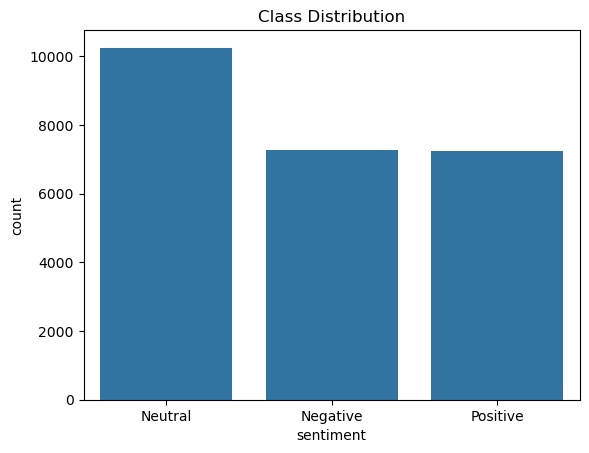

In [68]:
sns.countplot(data=tweet_data, x="sentiment")
plt.title('Class Distribution')
plt.show()

In [69]:
tweet_data.to_excel('preprcessed_labeled_data.xlsx',index=False)

In [70]:
tweet_data = pd.read_excel('preprcessed_labeled_data.xlsx')
print(tweet_data.shape)

(24783, 9)


In [71]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   count               24783 non-null  int64  
 1   hate_speech         24783 non-null  int64  
 2   offensive_language  24783 non-null  int64  
 3   neither             24783 non-null  int64  
 4   class               24783 non-null  int64  
 5   tweet               24782 non-null  object 
 6   preprocess_tweet    24783 non-null  object 
 7   polarity            24783 non-null  float64
 8   sentiment           24783 non-null  object 
dtypes: float64(1), int64(5), object(3)
memory usage: 1.7+ MB


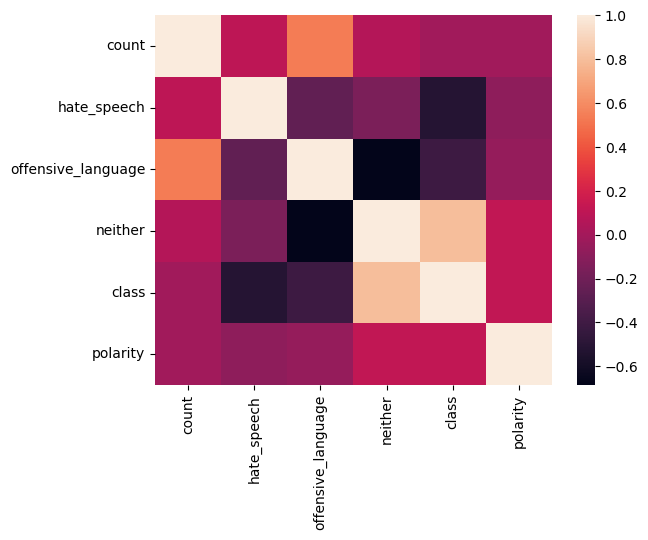

In [72]:
# Select only numeric columns
numeric_data = tweet_data.select_dtypes(include=[float, int])

# Calculate the correlation matrix
corr = numeric_data.corr()

# Plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()


# **Machine Learning**

In [73]:
X=tweet_data['preprocess_tweet']
Y=tweet_data['class']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.3, random_state = 42)

In [57]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(17348,)
(7435,)
(17348,)
(7435,)


In [59]:
vectoriser = CountVectorizer(max_features=1000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  1000


In [60]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


# 1. Naive Bayes

In [96]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

ValueError: y should be a 1d array, got an array of shape (17348, 3) instead.

In [ ]:
predictions=clf.predict(X_test)
score=clf.score(X_test,y_test)
print(f'Accuracy : {score*100:.2f}')

In [72]:
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.43      0.24      0.31       427
           1       0.90      0.95      0.93      5747
           2       0.80      0.73      0.76      1261

    accuracy                           0.87      7435
   macro avg       0.71      0.64      0.67      7435
weighted avg       0.86      0.87      0.86      7435



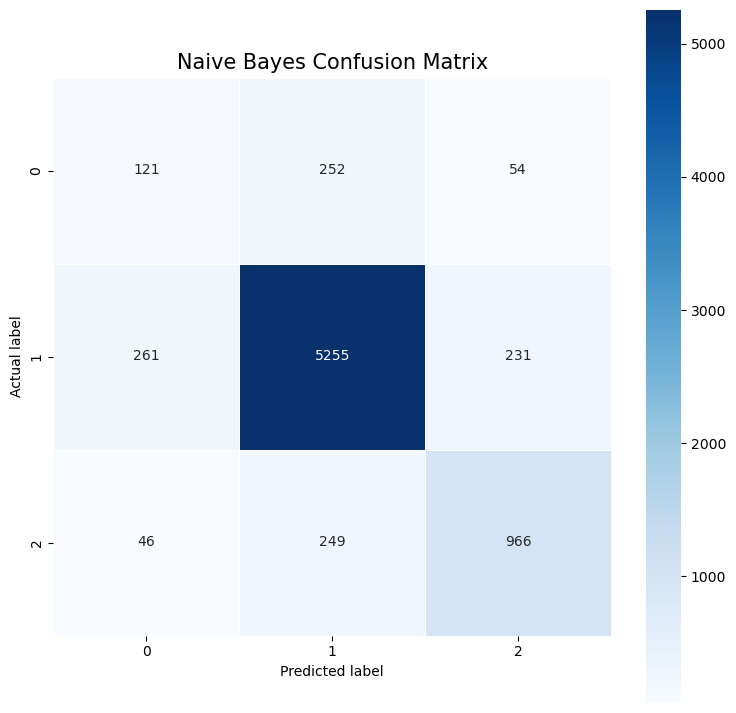

In [83]:
cm=metrics.confusion_matrix(y_test,predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square=True, cmap="Blues");
plt.ylabel("Actual label");
plt.xlabel("Predicted label")
all_sample_title="Naive Bayes Confusion Matrix"
plt.title(all_sample_title,size=15)
plt.show()

# 2. Decision Tree Classifier

In [75]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [78]:
predictions=clf.predict(X_test)
score=clf.score(X_test,y_test)
print(f'Accuracy : {score*100:.2f}')

Accuracy : 85.30


In [84]:
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.28      0.28      0.28       427
           1       0.91      0.91      0.91      5747
           2       0.77      0.77      0.77      1261

    accuracy                           0.85      7435
   macro avg       0.66      0.65      0.66      7435
weighted avg       0.85      0.85      0.85      7435



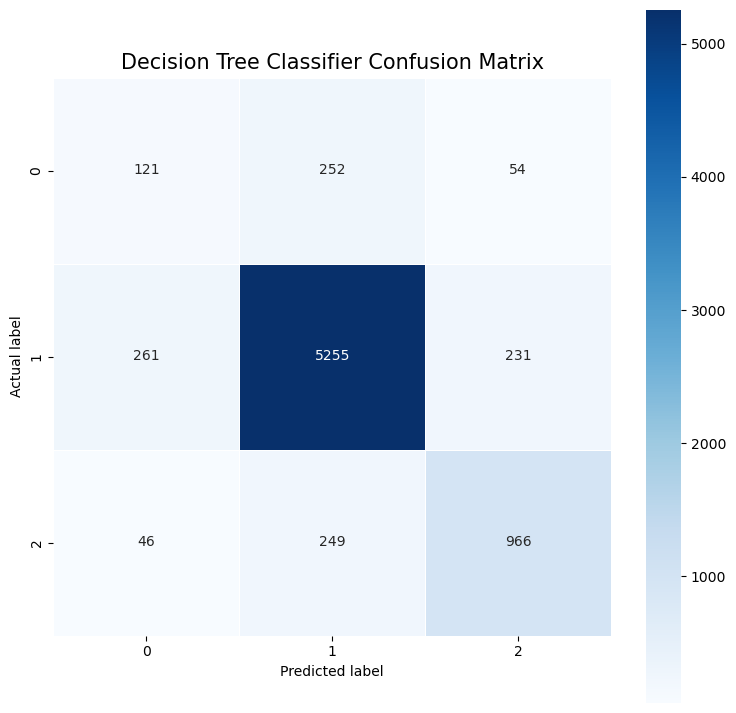

In [85]:
cm=metrics.confusion_matrix(y_test,predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square=True, cmap="Blues");
plt.ylabel("Actual label");
plt.xlabel("Predicted label")
all_sample_title="Decision Tree Classifier Confusion Matrix"
plt.title(all_sample_title,size=15)
plt.show()

# **DEEP LEARNING**

In [86]:
from tensorflow.keras.utils import to_categorical
y_train=to_categorical(y_train, num_classes = 3)
y_test=to_categorical(y_test, num_classes = 3)

In [87]:
X_train[1].shape

(1, 1000)

In [88]:
y_train.shape

(17348, 3)

In [89]:
X_train.shape

(17348, 1000)

In [91]:
model = Sequential([
    Embedding(24784, 100, input_length=X_train.shape[1]),
    SpatialDropout1D(0.2),
    Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.4),
    Flatten(),
    Dense(3, activation='softmax', kernel_regularizer=l2(0.01))
])

C:\Users\anand\miniconda3\envs\ids_project\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [92]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [93]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 77s 280ms/step - accuracy: 0.7968 - loss: 1.3829 - val_accuracy: 0.8467 - val_loss: 0.9165
Epoch 2/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 78s 288ms/step - accuracy: 0.8814 - loss: 0.5472 - val_accuracy: 0.8534 - val_loss: 0.5344
Epoch 3/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 77s 284ms/step - accuracy: 0.8917 - loss: 0.4189 - val_accuracy: 0.8780 - val_loss: 0.4409
Epoch 4/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 77s 283ms/step - accuracy: 0.8817 - loss: 0.4249 - val_accuracy: 0.8785 - val_loss: 0.4096
Epoch 5/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 78s 285ms/step - accuracy: 0.8805 - loss: 0.4136 - val_accuracy: 0.8670 - val_loss: 0.4242
Epoch 6/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 75s 275ms/step - accuracy: 0.8866 - loss: 0.4091 - val_accuracy: 0.8752 - val_loss: 0.4113
Epoch 7/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 76s 278ms/step - accuracy: 0.8920 - loss: 0.3952 - val_accuracy: 0.8810 - val_loss: 0.3998
Epoch 8/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 76s 280ms/step - accuracy: 0.8828 - loss: 0

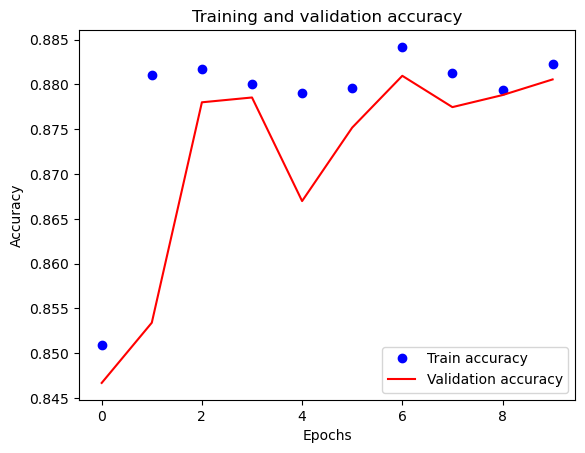

In [94]:
plt.plot(history.history['accuracy'], 'bo', label='Train accuracy')
plt.plot(history.history['val_accuracy'], 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

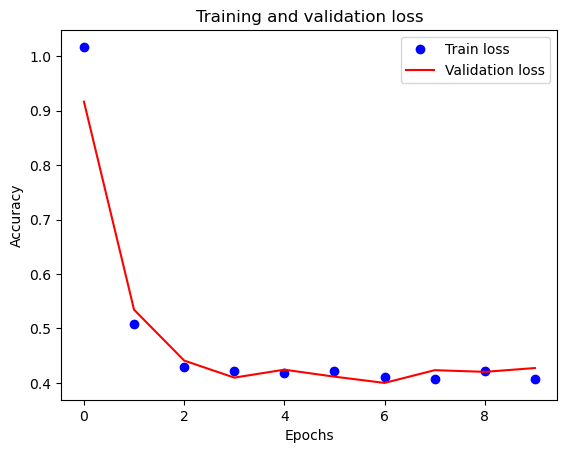

In [95]:
plt.plot(history.history['loss'], 'bo', label='Train loss')
plt.plot(history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [606]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# Build the LSTM model with L2 regularization
model = Sequential()

# Embedding Layer - A dense vector representation of words
model.add(Embedding(24784, 100, input_length=X_train.shape[1]))

# Spatial Dropout Layer to prevent overfitting by randomly dropping entire words
model.add(SpatialDropout1D(0.2))

# LSTM Layer to capture sequential dependencies in the text
model.add(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01)))

# BatchNormalization to stabilize and improve convergence
model.add(BatchNormalization())

# Dropout layer for further regularization
model.add(Dropout(0.4))

# Dense layer with softmax activation for multi-class classification, with L2 regularization
model.add(Dense(3, activation='softmax', kernel_regularizer=l2(0.01)))

# Compile the model with categorical crossentropy for multi-class classification
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Learning rate scheduler (to dynamically adjust learning rate based on validation loss)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[lr_scheduler])


Epoch 1/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 581s 1s/step - accuracy: 0.6920 - loss: 1.2792 - val_accuracy: 0.7730 - val_loss: 0.6936 - learning_rate: 0.0010
Epoch 2/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 571s 1s/step - accuracy: 0.7766 - loss: 0.6883 - val_accuracy: 0.7730 - val_loss: 0.6802 - learning_rate: 0.0010
Epoch 3/10
 34/543 ━━━━━━━━━━━━━━━━━━━━ 7:51 926ms/step - accuracy: 0.7874 - loss: 0.6563


KeyboardInterrupt

